# Preparation

## Import packages

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Prophet import
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [3]:
# ARIMA import
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, acf
from statsmodels.graphics.tsaplots import plot_pacf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from scipy import fft

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# LSTM import
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.
/home/energiya/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:936: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/energiya/.local/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  return _inspect.getargspec(target)


## Define required functions

In [5]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(14).mean()
    rolstd = timeseries.rolling(14).mean()

    #Plot rolling statistics:
    plt.figure(figsize=(10, 7))
    orig = plt.plot(timeseries,'.', color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [6]:
# convert an array of values into a dataset matrix used in LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(7)

In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Read data

In [11]:
amb_hour_csv = "amb_hour.csv"
dtypes = {
    'Date': 'str',
    'SCH HRS': 'int',
    'ACT HRS': 'int',
    'Total 911 TX': 'int',
    'OOS Hrs': 'float',
    'PRI 1&2': 'int',
    'PRI 3': 'int',
    'PRI 4 ALS': 'int',
    'PRI 4 GT': 'int',
    'ALS GT TX': 'int',
    'CBA': 'int',
    'COS': 'int',
    'TOTAL': 'int',
    'Total': 'int',
    "TX's": 'int',
    'DISP': 'int'
}
parse_dates = ['Date']
data_amb_hour = pd.read_csv(amb_hour_csv, parse_dates=parse_dates)

Text(0,0.5,'ACT HRS')

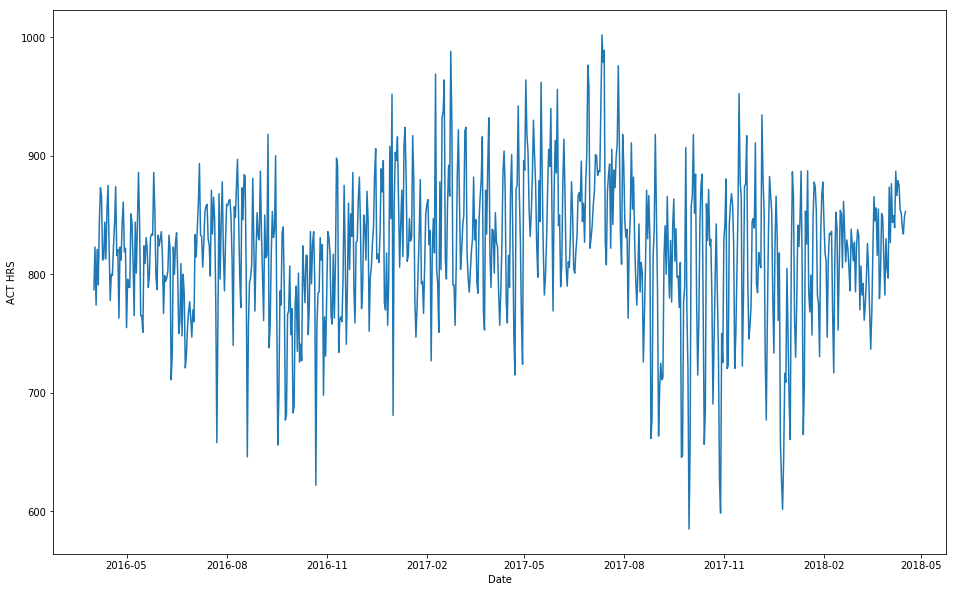

In [12]:
data_amb_hour = data_amb_hour[:-44]
plt.figure(figsize=(16, 10))
plt.plot(data_amb_hour['Date'], data_amb_hour['ACT HRS'])
plt.xlabel('Date')
plt.ylabel('ACT HRS')

In [13]:
len(data_amb_hour)

747

# Prophet analysis

In [14]:
df_act_hrs = pd.DataFrame(data_amb_hour['Date'].values)
df_act_hrs['y'] = data_amb_hour['ACT HRS'].values
df_act_hrs.columns = ['ds', 'y']

m_act_hrs = Prophet(daily_seasonality=False)
m_act_hrs.fit(df_act_hrs)
future = m_act_hrs.make_future_dataframe(periods=90)
forecast = m_act_hrs.predict(future)

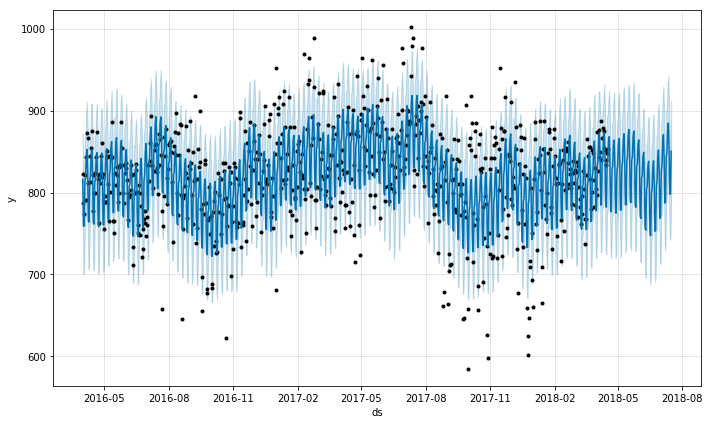

In [15]:
fig = m_act_hrs.plot(forecast)

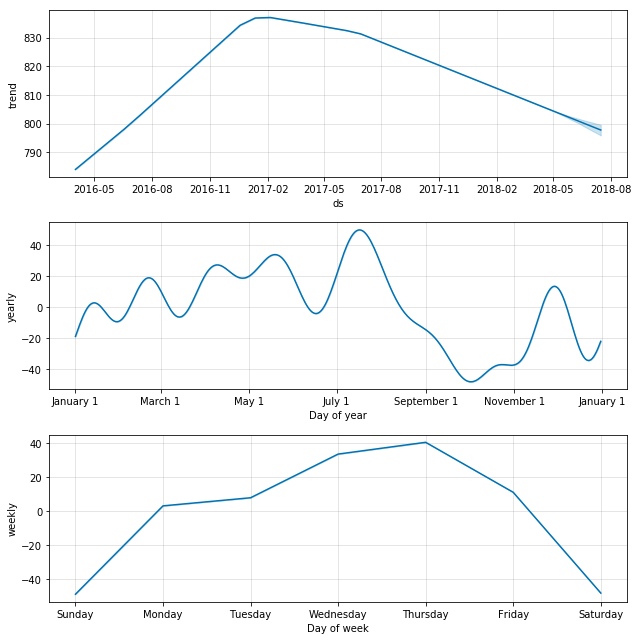

In [16]:
fig = m_act_hrs.plot_components(forecast)

In [14]:
df_cv = cross_validation(m_act_hrs, initial='606 days', period='1 days', horizon = '140 days')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet.diagnostics:Making 1 forecasts with cutoffs between 2017-11-28 00:00:00 and 2017-11-28 00:00:00


,horizon,mse,rmse,mae,mape,coverage
13,14 days,1849.865886,43.010067,36.414101,0.045503,0.857143
14,15 days,1899.875306,43.587559,37.205731,0.046291,0.857143
15,16 days,1820.467365,42.666935,35.436052,0.044388,0.857143
16,17 days,1688.027500,41.085612,33.730262,0.042060,0.857143
17,18 days,1705.601997,41.298935,34.405848,0.042933,0.857143


# ARIMA analysis

In [17]:
act_hrs_series = pd.Series(data_amb_hour['ACT HRS'].values, index=data_amb_hour['Date'].values)

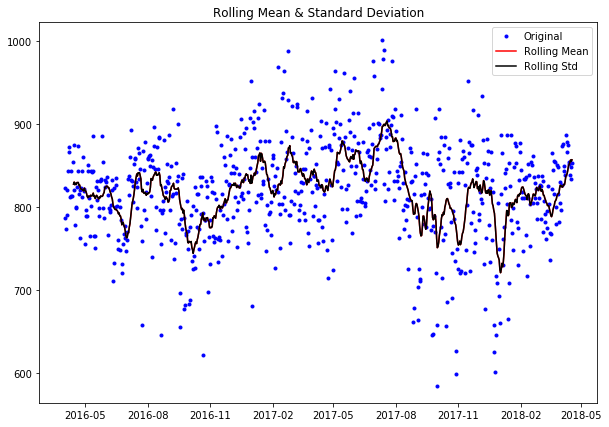

Results of Dickey-Fuller Test:
Test Statistic                  -3.462278
p-value                          0.009010
#Lags Used                      13.000000
Number of Observations Used    733.000000
Critical Value (10%)            -2.568874
Critical Value (1%)             -3.439303
Critical Value (5%)             -2.865491
dtype: float64


In [18]:
test_stationarity(act_hrs_series)

Text(0.5,1,'Residual')

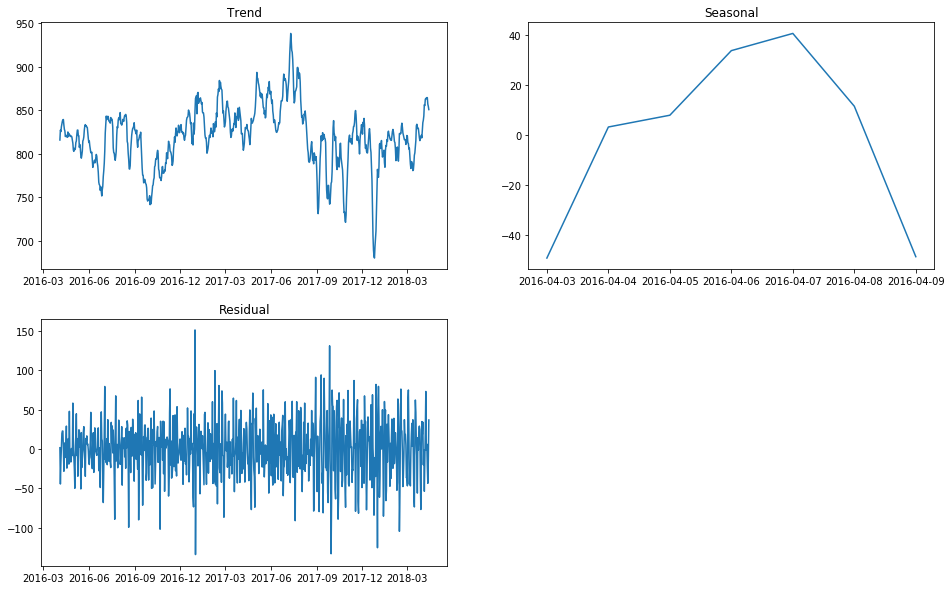

In [19]:
decomposition = seasonal_decompose(act_hrs_series, freq=7)

fig = plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.subplot(2, 2, 2)
plt.plot(decomposition.seasonal[2:9])
plt.title('Seasonal')
plt.subplot(2, 2, 3)
plt.plot(decomposition.resid)
plt.title('Residual')

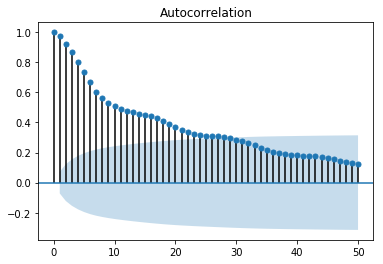

In [20]:
fig = plot_acf(decomposition.trend[3:-3], lags=50)

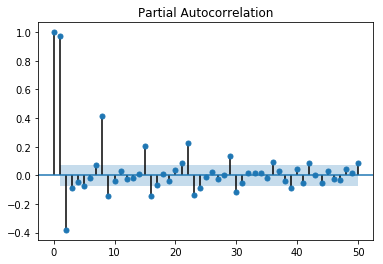

In [21]:
fig = plot_pacf(decomposition.trend[3:-3], lags=50)

In [22]:
act_hrs_diff = act_hrs_series - act_hrs_series.shift(7)
act_hrs_diff = act_hrs_diff[7:]

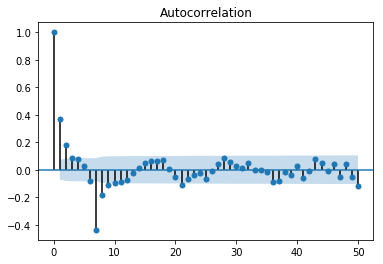

In [23]:
fig = plot_acf(act_hrs_diff, lags=50)

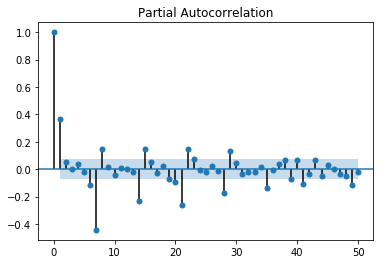

In [24]:
fig = plot_pacf(act_hrs_diff, lags=50)

In [34]:
mod = SARIMAX(act_hrs_series,order=(3, 1, 3), #seasonal_order=(1, 1, 1, 52),
                                enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary())

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/statespace/sarimax.py:1042: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  747
Model:              SARIMAX(7, 1, 10)   Log Likelihood               -3783.275
Date:                Thu, 06 Dec 2018   AIC                           7602.550
Time:                        12:59:14   BIC                           7685.639
Sample:                    04-01-2016   HQIC                          7634.572
                         - 04-17-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0376      0.052      0.725      0.469      -0.064       0.139
ar.L2         -0.1396      0.054     -2.580      0.010      -0.246      -0.034
ar.L3          0.0412      0.052      0.788      0.4

/home/energiya/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


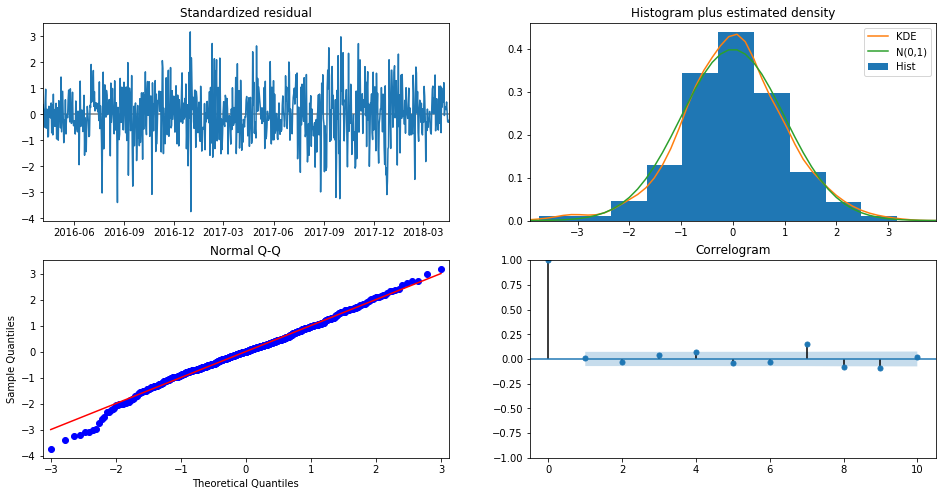

In [24]:
fig = results.plot_diagnostics(figsize=(16, 8))

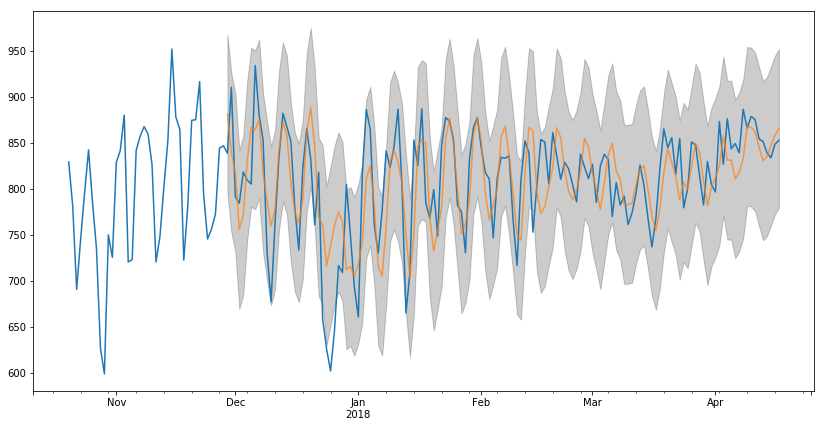

In [25]:
pred = results.get_prediction(start=pd.to_datetime('2017-11-29'), dynamic=False)
pred_ci = pred.conf_int()
ax = act_hrs_series[-180:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

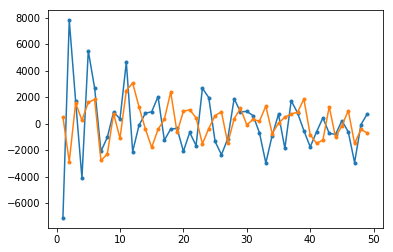

In [26]:
fft_hrs = np.fft.rfft(act_hrs_series)
plt.plot(np.arange(1,50), fft_hrs.real[1:50],'.-')
plt.plot(np.arange(1,50), fft_hrs.imag[1:50],'.-')

# LSTM analysis

In [27]:
dataset = act_hrs_series.values
dataset = dataset.astype('float32')

In [28]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

In [29]:
# split into train and test sets
train_size = len(dataset) - 140 #int(len(dataset) * 0.67)
test_size = 140 #len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

607 140


In [30]:
# reshape into X=t and Y=t+1
look_back = 28
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [31]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [32]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
#model.add(LSTM(64, input_shape=(1, look_back)))
model.add(LSTM(16, batch_input_shape=(batch_size, 1, look_back), stateful=True, return_sequences=True))
model.add(LSTM(16, batch_input_shape=(batch_size, 1, look_back), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)
#for i in range(100):
#    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
#    model.reset_states()

Epoch 1/100
578/578 [==============================] - 1s 2ms/step - loss: 0.0309
Epoch 2/100
578/578 [==============================] - 1s 1ms/step - loss: 0.0226
Epoch 3/100
578/578 [==============================] - 1s 1ms/step - loss: 0.0204
Epoch 4/100
578/578 [==============================] - 1s 1ms/step - loss: 0.0178
Epoch 5/100
578/578 [==============================] - 1s 1ms/step - loss: 0.0156
Epoch 6/100
578/578 [==============================] - 1s 1ms/step - loss: 0.0156
Epoch 7/100
578/578 [==============================] - 1s 1ms/step - loss: 0.0151
Epoch 8/100
578/578 [==============================] - 1s 1ms/step - loss: 0.0138
Epoch 9/100
578/578 [==============================] - 1s 1ms/step - loss: 0.0142
Epoch 10/100
578/578 [==============================] - 1s 1ms/step - loss: 0.0136
Epoch 11/100
578/578 [==============================] - 1s 1ms/step - loss: 0.0135
Epoch 12/100
578/578 [==============================] - 1s 1ms/step - loss: 0.0128
Epoch 13/100


In [33]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 41.29 RMSE
Test Score: 41.46 RMSE


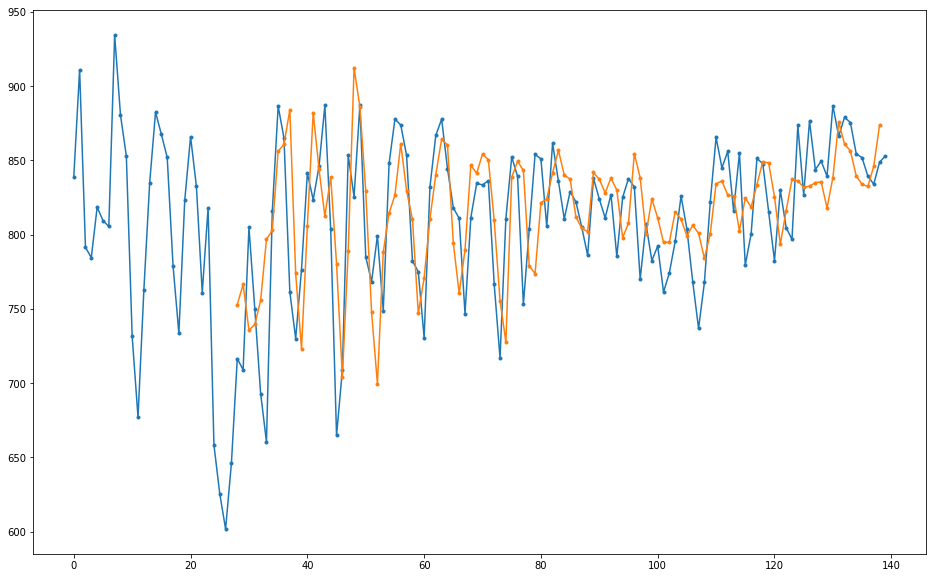

In [34]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(16, 10))
plt.plot(scaler.inverse_transform(dataset)[-140:],'.-')
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot[-140:],'.-')

# Comparison

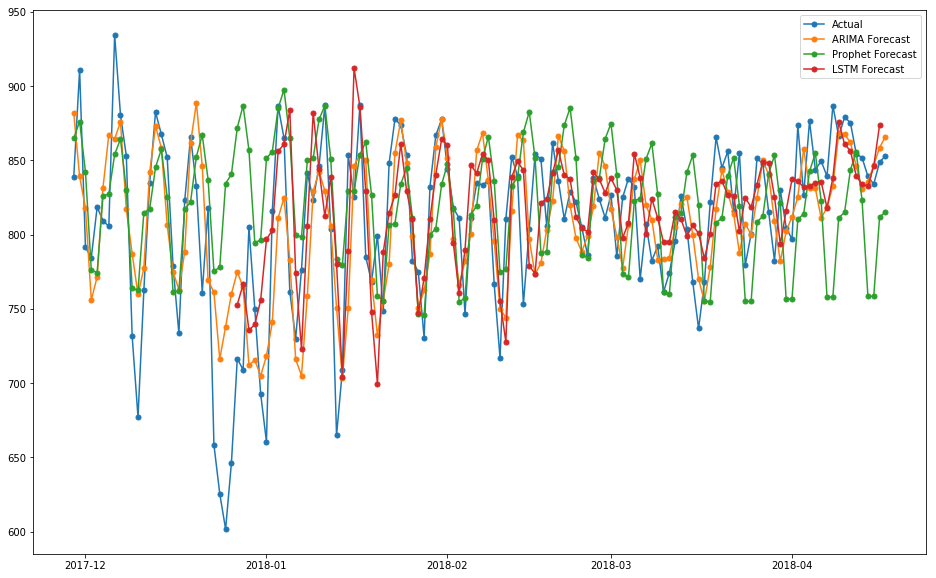

In [35]:
plt.figure(figsize=(16, 10))
plt.plot(act_hrs_series[-140:],'.-', markersize=10, linewidth=1.5, label = 'Actual')
plt.plot(pred.predicted_mean,'.-', markersize=10, linewidth=1.5, label = 'ARIMA Forecast')
plt.plot(df_cv['ds'],df_cv['yhat'],'.-', markersize=10, linewidth=1.5, label = 'Prophet Forecast')
plt.plot(df_cv['ds'],testPredictPlot[-140:],'.-', markersize=10, linewidth=1.5, label = 'LSTM Forecast')
plt.legend()

In [36]:
print('ARIMA MAPE:', mean_absolute_percentage_error(act_hrs_series.values[-140:],pred.predicted_mean.values),'%')

ARIMA MAPE: 4.2860367686978 %


In [37]:
print('Prophet MAPE:', mean_absolute_percentage_error(act_hrs_series.values[-140:],df_cv['yhat'].values),'%')

Prophet MAPE: 5.901691173377861 %


In [38]:
print('LSTM MAPE:', mean_absolute_percentage_error(act_hrs_series.values[-111:-1],testPredictPlot[-111:-1].reshape(1,-1)[0]),'%')

LSTM MAPE: 4.051641491966499 %
